In [1]:
import librosa
import librosa.display
import os
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
def mfcc(data):
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc_audio = librosa.feature.mfcc(y=data, sr=22050, n_fft=512).flatten()

    return mfcc_audio

In [4]:
def mfcc(data):
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc_audio = librosa.feature.mfcc(y=data, sr=22050, n_fft=512).flatten()

    return mfcc_audio

#current_path = os.path.dirname(os.path.realpath(__file__))

#songs = pd.read_csv(os.path.join(current_path, "dataset_audio.csv"))
songs = pd.read_csv("dataset_audio.csv")
time = list(songs["Time Series"])

In [5]:
time_str = [i.replace("[", "") for i in time]
time_str = [i.replace("]", "") for i in time_str]
preprocessed_data = [np.fromstring(i, dtype=float, sep=',') for i in time_str]

In [6]:
sr = 22050
audio_separate = []
for data in preprocessed_data:
    for i in range(0, 25):
        start = i*sr
        end = (i+1)*sr
        audio_separate.append(data[start:end])

In [16]:
mfcc_audio_data = []    # Mel-frequency cepstral coefficients (MFCCs)

for data in audio_separate:
    # dataset after feature extraction
    mfcc_audio = mfcc(np.array(data))
    mfcc_audio_data.append(mfcc_audio)
    #mfcc_audio_data.append(mfcc_audio.reshape(880, 1))
    
mfcc_audio_data = np.array(mfcc_audio_data)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(mfcc_audio_data)
mfcc_audio_data = scaler.transform(mfcc_audio_data)

In [18]:
mfcc_audio_data.shape

(2500, 880)

In [36]:
mfcc_norm = []
for data in mfcc_audio_data:
    mfcc_norm.append(data.reshape(40, 22))

mfcc_norm = np.array(mfcc_norm)

In [37]:
mfcc_norm.shape

(2500, 40, 22)

In [38]:
singers_old = list(songs["Singer"])
singers = []

for singer in singers_old:
    for i in range(0, 25):
        singers.append(singer)

singers = np.array(singers)

In [39]:
singers.shape

(2500,)

In [40]:
label_encoder = LabelEncoder()
Y_label_encoded = label_encoder.fit_transform(singers)

# Convert NumPy arrays to PyTorch tensors
#X_tensor = torch.tensor(mfcc_audio_data, dtype=torch.float32)
#Y_label_encoded_tensor = torch.tensor(Y_label_encoded, dtype=torch.long)

X_train, X_test, train_Y, test_Y = train_test_split(mfcc_norm, Y_label_encoded, test_size = 0.2, random_state = 42)

In [41]:
X_train.shape

(2000, 40, 22)

In [42]:
train_Y

array([8, 7, 7, ..., 4, 5, 3], dtype=int64)

In [67]:
from sklearn.metrics import accuracy_score
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

In [44]:
X_train = X_train.reshape(X_train.shape[0], 40, 22, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 40, 22, 1).astype('float32')

#one hot encoding
Y_train = to_categorical(train_Y)
Y_test = to_categorical(test_Y)

In [45]:
'''Accuracy'''
test = list(test_Y)
num = [test.count(0), test.count(1), test.count(2), test.count(3), test.count(4), test.count(5), test.count(6), test.count(7), test.count(8), test.count(9)]
def acc(pred):
  accuracy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  for i in range(0, len(pred)):
    for j in range(0, 10):
      if pred[i] == test_Y[i]:
        accuracy[pred[i]] += 1
        break
  for i in range(0, 10):
    accuracy[i] = accuracy[i]/num[i]
  return accuracy

In [69]:
model = Sequential()
'''model.add(Conv2D(32, (5, 5), input_shape=(40, 22, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))

model.add(Dense(Y_test.shape[1]))
model.add(Activation('softmax'))'''


model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(40, 22, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=50)

Epoch 1/50
63/63 [==============================] - 1s 7ms/step - loss: 1.9724 - accuracy: 0.3150 - val_loss: 1.7562 - val_accuracy: 0.3960
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 1.5114 - accuracy: 0.4940 - val_loss: 1.5149 - val_accuracy: 0.4960
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 1.2721 - accuracy: 0.5730 - val_loss: 1.4881 - val_accuracy: 0.5040
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 1.0880 - accuracy: 0.6405 - val_loss: 1.4472 - val_accuracy: 0.5080
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 0.9070 - accuracy: 0.6940 - val_loss: 1.3308 - val_accuracy: 0.5460
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 0.7536 - accuracy: 0.7485 - val_loss: 1.2816 - val_accuracy: 0.5780
Epoch 7/50
63/63 [==============================] - 0s 5ms/step - loss: 0.6341 - accuracy: 0.7950 - val_loss: 1.3634 - val_accuracy: 0.5540
Epoch 8/50
63/63 [==

In [71]:
scores = model.evaluate(X_test, Y_test)
print("Loss: {}".format(scores[0]))
print("Accuracy: {}".format(scores[1]))

16/16 [==============================] - 0s 5ms/step - loss: 2.2039 - accuracy: 0.6000
Loss: 2.203892230987549
Accuracy: 0.6000000238418579


In [65]:
predictions = model.predict(X_test)
pred = []
for x in range(0, len(predictions)):
  pred.append((np.argmax(np.round(predictions[x]))))

In [61]:
import matplotlib.pyplot as plt

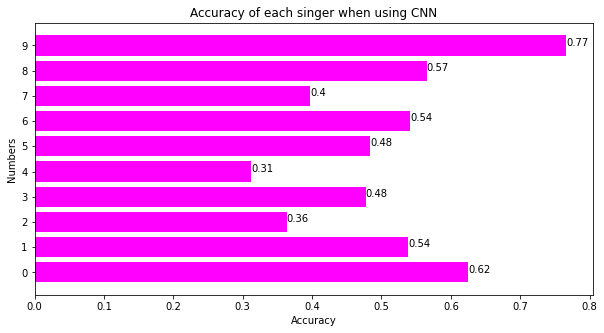

In [73]:
'''Results Visualization for CNN'''
accuracy = acc(pred)

fig = plt.figure(figsize = (10, 5))
num_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.barh(num_labels, accuracy, color="magenta")
plt.yticks(num_labels)
plt.xlabel("Accuracy")
plt.ylabel("Numbers")
plt.title("Accuracy of each singer when using CNN")
for index, value in enumerate(accuracy):
  plt.text(value, index, str(round(value, 2)))
plt.show()